# Depot tests in Bellach







In this script we analyse the data collected during the second round of the depot tests (Reihe 2 der Werkhofversuche in Bellach). Specifically, we analyse the strain gauges data.

**Input:**

*   a csv-file '`DMS_vdata.csv`'. It contains the data collected with the strain gauges glued on the two sheet piles.

**Output:**

*   no libraries are created in this Jupyter-Notebook.

**Note:** The code was originally written by Mr. Amin Moussaid, who is a native French speaker. For the sake of readability, the Jupyter-Notebook has been translated into English and restructured slightly. The code itself (e.g. variable names), however, was left as is.

**Note:** For some reason, when converting this Jupyter Notebook to a Pdf file, the interactive plots are omitted. These figures can be requested at jean-baptiste.payeur@bfh.ch.

In [1]:
from google.colab import drive
drive.mount('/content/drive')

# working directory: drive/MyDrive/spundsteif
%cd '/content/drive/MyDrive/spundsteif'

%load_ext autoreload
%autoreload 2

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/MyDrive/spundsteif


# Import the libraries

In [2]:
import pandas as pd
import numpy as np
import io

from google.colab import files

import plotly.express as px
import plotly.graph_objects as go

from sklearn.linear_model import LinearRegression

# Import the data

The data is saved on the BFH server at following location: `P:\AHB\FE\02_PT\80_SI\81_GNE\81FE-010202-K-01_innosuisse_Entwicklung eines neuen Spundwandsystems\AP1\Werkhof\Ergebnisse\Reihe 2`

File name:
`DMS_vdata.csv`

In [3]:
# create a dataframe containing the raw data

def reset_df():
  df = pd.read_csv('./data/DMS_vdata.csv', sep=';')
  return df

df = reset_df()

In [4]:
df

,x,y,num_dms,serr_long,serr_type,eps,force,essai,charg
0,-600,22,1,0.3,sch,0,2,versuche 2.1.1,1
1,-600,22,1,0.3,sch,262,22,versuche 2.1.1,1
2,-600,22,1,0.3,sch,735,53,versuche 2.1.1,1
3,-600,22,1,0.3,sch,1305,105,versuche 2.1.1,1
4,-600,22,1,0.3,sch,830,53,versuche 2.1.1,0
...,...,...,...,...,...,...,...,...,...
483,600,-22,8,15.0,klebt,-177,29,versuche 2.2.3,1
484,600,-22,8,15.0,klebt,-430,58,versuche 2.2.3,1
485,600,-22,8,15.0,klebt,-783,96,versuche 2.2.3,1
486,600,-22,8,15.0,klebt,-1028,120,versuche 2.2.3,1


# Basic functions to treat the data

The raw data is structured as follows:

*   **x** , **y** - *int* , *int* : position of the strain gauge in the cross-section, in [mm]
*   **num_dms** - *int* : number of the strain gauge
*   **serr_long** - *float* : lock length at the top of the sheet pile (between 0.3 and 15m), in [m]
*   **serr_type** - *str* : lock type, welded ('sch'=verschweisst) or grouted ('klebt'=verklebt)
*   **eps** - *int* : measured value of the strain, in [micrometers per meter]
*   **force** - *int* : force applied during the test, in [kN]
*   **essai** - *str* : name of the test
*   **charg** - *int* : 1 and 0 represent the loading and unloading phases, respectively

Before we can proceed to analyse the data, we must perform a few pre-processing steps.


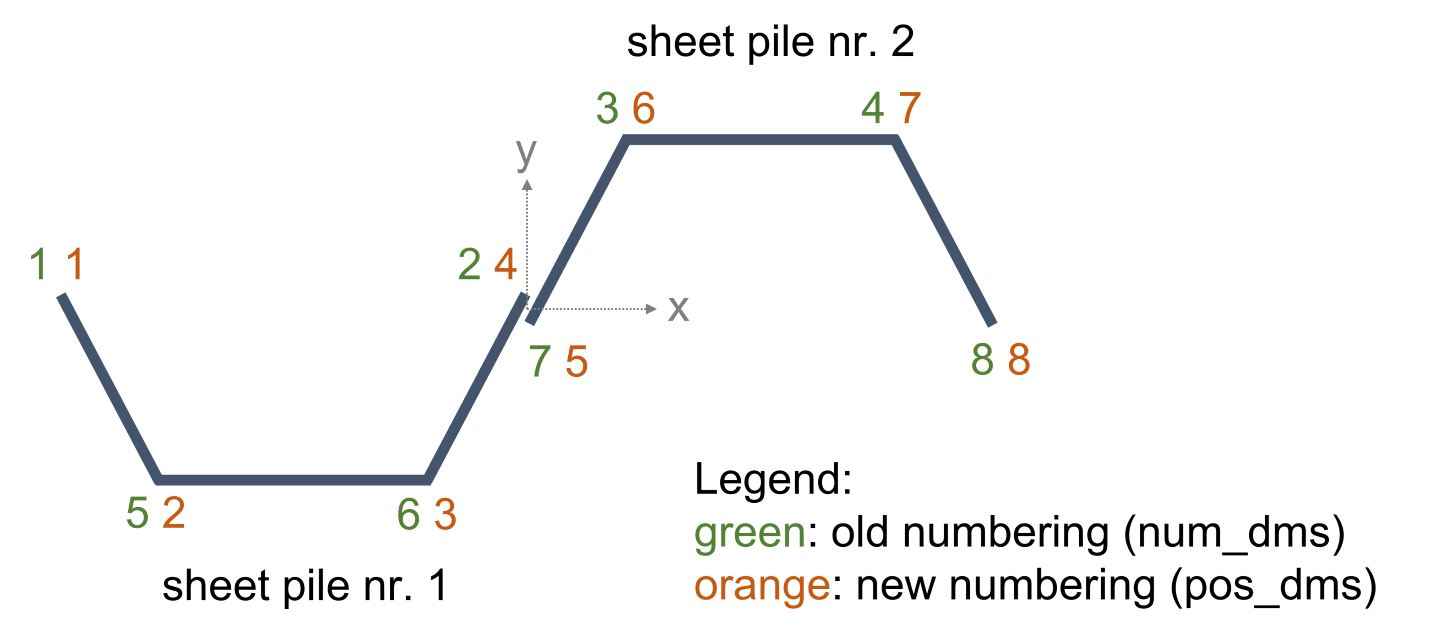

In [5]:
# Select the strain gauges measurements for a given load step

def projection_chargement(serr_long, serr_type, force, charg):
  return df.loc[(df['force'] == force) & (df['serr_type'] == serr_type) &
                (df['serr_long'] == serr_long) & (df['charg'] == charg)]

In [6]:
# Change the strain gauge number and add an index to identify the left and the
# right pile

def add_pos_dms(df):
  position_dictionary = {1:1, 5:2, 6:3 , 2:4, 7:5, 3:6, 4:7, 8:8}
  df['pos_dms'] = df['num_dms'].map(position_dictionary)
  df['indice_pal'] = np.where(df['pos_dms'] <= 4, 1, 2)
  return df

In [7]:
# Sometimes, even when no force was applied on the piles, the strain gauges
# recorded a value different from zero. In order to remove this effect, we go
# through each empirical value in the dataframe and subtract the eps value
# (strain gauge measurement) of the very first load step.

def deformations_elastiques(df):
  serr_long = df['serr_long']
  serr_type = df['serr_type']
  serr = list(zip(serr_long, serr_type))
  serr = list(set(serr))

  for serr_long, serr_type in serr:
    force_min = df.loc[(df['serr_long'] == serr_long) &
                       (df['serr_type'] == serr_type) &
                       (df['charg'] == 1)]['force'].min()

    #Etat initial
    df_etat_initial = df.loc[(df['serr_long'] == serr_long) &
                             (df['serr_type'] == serr_type) &
                             (df['force'] == force_min)
                             & (df['charg'] == 1)]

    df_etat_initial.sort_values('num_dms')
    eps_initial = list(df_etat_initial['eps'])

    forces = df.loc[(df['serr_long'] == serr_long) &
                    (df['serr_type'] == serr_type)]['force']
    charges = df.loc[(df['serr_long'] == serr_long) &
                     (df['serr_type'] == serr_type)]['charg']
    forces_charges = list(zip(forces, charges))
    forces_charges = list(set(forces_charges))

    for force, charg in forces_charges:
      #Etat dans le temps sous la force 'force'
      df_temps = df.loc[(df.serr_long == serr_long) &
                        (df.serr_type == serr_type) &
                        (df.force == force) &
                        (df.charg == charg)]
      df_temps.sort_values('num_dms')
      eps_temps = list(df_temps['eps'])

      for i in range(len(eps_temps)):
        df.loc[(df.serr_long == serr_long) &
               (df.serr_type == serr_type) &
               (df.force == force) &
               (df.charg == charg) &
               (df.num_dms == i+1), 'new_eps'] \
             = eps_temps[i] - eps_initial[i]
  return df

In [8]:
# process the raw data

df = reset_df()
df = deformations_elastiques(df)
add_pos_dms(df)

,x,y,num_dms,serr_long,serr_type,eps,force,essai,charg,new_eps,pos_dms,indice_pal
0,-600,22,1,0.3,sch,0,2,versuche 2.1.1,1,0.0,1,1
1,-600,22,1,0.3,sch,262,22,versuche 2.1.1,1,262.0,1,1
2,-600,22,1,0.3,sch,735,53,versuche 2.1.1,1,735.0,1,1
3,-600,22,1,0.3,sch,1305,105,versuche 2.1.1,1,1305.0,1,1
4,-600,22,1,0.3,sch,830,53,versuche 2.1.1,0,830.0,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...
483,600,-22,8,15.0,klebt,-177,29,versuche 2.2.3,1,-177.0,8,2
484,600,-22,8,15.0,klebt,-430,58,versuche 2.2.3,1,-430.0,8,2
485,600,-22,8,15.0,klebt,-783,96,versuche 2.2.3,1,-783.0,8,2
486,600,-22,8,15.0,klebt,-1028,120,versuche 2.2.3,1,-1028.0,8,2


# Evaluation of sheet pile local behaviour

In order to quantify the static behaviour of the sheet piles we compute numerically the position of the neutral axes. the following notation is used:

*   DB = double piles (in German "Doppelbohlen")
*   2EB = two single piles (in German "zwei Einzelbohlen")

## Interpolation functions

In [9]:
def interpolation_2EB(df_char):

  """
  A partir d'une df de chargement (8 entrées) on interpole les données
  selon le modèle des 2EB

  Renvoie une liste de taille 2, contenant les 2 4-uplets contenant les
  coef des régressions linéaires (A, B, C, R^2)
  """

  assert len(df_char) == 8
  assert type(df_char) is pd.core.frame.DataFrame

  sortie = []
  indices_pal = df_char.indice_pal.unique()
  indices_pal.sort()

  for i in indices_pal:
    # Données dans la palplanche i
    df_pal = df_char.loc[df_char['indice_pal'] == i]
    # Vecteur position palplanche i
    X = np.transpose(np.array([df_pal['x'] , df_pal['y']]))
    y = df_pal['eps']

    reg = LinearRegression().fit(X,y)
    R = reg.score(X,y)

    sortie.append((reg.coef_[0], reg.coef_[1], reg.intercept_, R))

  return sortie

In [10]:
def interpolation_2EB_elastique(df_char):

  """
  A partir d'une df de chargement (8 entrées) on interpole les données
  selon le modèle des 2EB

  Renvoie une liste de taille 2, contenant les 2 4-uplets contenant les
  coef des régressions linéaires (A, B, C, R^2)
  """

  assert len(df_char) == 8
  assert type(df_char) is pd.core.frame.DataFrame

  sortie = []
  indices_pal = df_char.indice_pal.unique()
  indices_pal.sort()

  for i in indices_pal:
    # Données dans la palplanche i
    df_pal = df_char.loc[df_char['indice_pal'] == i]
    # Vecteur position palplanche i
    X = np.transpose(np.array([df_pal['x'] , df_pal['y']]))
    y = df_pal['new_eps']

    reg = LinearRegression().fit(X,y)
    R = reg.score(X,y)

    sortie.append((reg.coef_[0], reg.coef_[1], reg.intercept_, R))

  return sortie

In [11]:
def _interpolation_DB(df_char):

  """
  A partir d'une df de chargement (8 entrées) on interpole les données selon le
  modèle des DB
  """

  assert len(df_char) <= 8, \
    'Interpolation possible uniquement pour des données d un chargement'
    # On laisse valable le cas ou on aurait moins de mesures
  assert type(df_char) is pd.core.frame.DataFrame

  X = np.transpose(np.array([df_char['x'] , df_char['y']]))  # Vecteur position
  y = df_char['eps']

  reg = LinearRegression().fit(X, y)
  R = reg.score(X,y)

  sortie = (reg.coef_[0], reg.coef_[1] , reg.intercept_, R)

  return sortie

In [12]:
def _interpolation_chargement(df_char):

  """
  Renvoie les coefs du modèle le plus adapté à la distribution des déformations
  """

  if len(df_char) != 8:
    print("Erreur : Interpolation uniquement pour des données de chargement")
    return False

  # Calcul des coefficients des 2 modèles
  coef_DB = _interpolation_DB(df_char)
  coef_2EB = interpolation_2EB(df_char)

  if coef_DB[3] < 0.9:
    return coef_2EB
  elif coef_DB[3] >= 0.9:
    return coef_DB

## Grafical representation

In [13]:
def axe_neutre(c, x_min, x_max):
  """
  Construit 3 listes pour représenter l'axe neutre d'une interpolation
  dans l'espace (x, y, eps)
  """

  assert type(c) is tuple, 'Fonction qui trace l axe neutre a partir des coef d une regression linéaire'
  assert x_max > x_min, 'Vérifier les bornes du dessin'

  if c[1] == 0:
    return [], [], []

  x = np.linspace(x_min, x_max, 10)
  y = - 1 / c[1] * (c[0] * x + c[2])
  z = np.zeros(10)

  return x, y, z

In [14]:
def representation_2EB(coef_reg, df_char):
  assert type(coef_reg) is list, 'Entrée doit être liste'
  assert len(coef_reg) == 2, 'Vérifier le modèle utilisé (DB ou 2EB)'

  X = []
  Y = []
  Z = []

  axe_n = []

  # Permet de choisir la zone de dessin des objets pour chaque palplanche
  X_SIZE = [[-700,100] , [-100,700]]
  Y_SIZE = [[-300,100] , [-100,300]]

  # Construction des données pour chacune des palplanches
  for i in [0,1]:
    c = coef_reg[i]
    print(c)
    x = np.linspace(X_SIZE[i][0], X_SIZE[i][1], 10)
    y = np.linspace(Y_SIZE[i][0], Y_SIZE[i][1], 10)
    xGrid, yGrid = np.meshgrid(x, y)
    z = c[0]*xGrid + c[1]*yGrid + c[2]

    axe_n.append(axe_neutre(c, X_SIZE[i][0], X_SIZE[i][1]))
    X.append(xGrid)
    Y.append(yGrid)
    Z.append(z)

  eps_min = min(np.amin(Z[0]) , np.amin(Z[1]))
  eps_max = max(np.amax(Z[0]) , np.amax(Z[1]))

  df_char = df_char.sort_values('pos_dms')

  fig = go.Figure(data=[
      # Tracé du plan des deformations de la palplanche 1
      go.Surface(x=X[0], y=Y[0], z=Z[0],
                 name='Interpolation - Spundbohle 1',
                 opacity = 0.8,
                 colorbar_x=1, colorbar_title='Spundbohle 1',
                 colorbar_thickness=20, colorbar_len=0.5,
                 autocolorscale=False,
                 colorscale=[[0, 'rgb(7,64,80)'],
                             [0.5, 'rgb(255,255,255)'],
                             [1, 'rgb(154,205,50)']],
                 cmin=eps_min, cmax=eps_max, cmid=0
                 ),
      # Tracé de l'axe neutre de la palplanche 1
      go.Scatter3d(x=axe_n[0][0], y=axe_n[0][1], z=axe_n[0][2],
                   name='Neutral Achse - Spundbohle 1',
                   mode='lines', line=dict(color='rgb(255,127,80)', width=3,
                                           dash="longdash")
                   ),
      # Tracé du plan des deformations de la palplanche 2
      go.Surface(x=X[1], y=Y[1], z=Z[1],
                 name='Interpolation - Spundbohle 2',
                 opacity = 0.8,
                 colorbar_x=1.15, colorbar_title='Spundbohle 2',
                 colorbar_thickness=20, colorbar_len=0.5,
                 autocolorscale=False,
                 colorscale=[[0, 'rgb(7,64,80)'],
                             [0.5, 'rgb(255,255,255)'],
                             [1, 'rgb(34,139,34)']],
                 cmin=eps_min, cmax=eps_max, cmid=0
                 ),
      # Tracé de l'axe neutre de la palplanche 2
      go.Scatter3d(x=axe_n[1][0], y=axe_n[1][1], z=axe_n[1][2],
                   name='Neutral Achse - Spundbohle 2',
                   mode='lines', line=dict(color='rgb(218,165,32)', width=3,
                                           dash="longdash")
                  ),
      ])

  # Profil de la section
  fig.add_traces(go.Scatter3d(x=df_char['x'], y=df_char['y'], z=[0]*8,
                   name='Spundbohle Profil',
                   mode='lines',
                   line=dict(color='rgb(112,128,144)', width=5)
                   )
                )
  # Valeurs expérimentales
  fig.add_traces(go.Scatter3d(x=df_char['x'], y=df_char['y'], z=df_char['eps'],
                  name='Experimentelle Messungen',
                  mode='markers', marker_symbol='x',
                  marker_size=3, marker_color='#17BECF'
                  )
                 )

  fig.update_layout(scene = dict(zaxis_title='Dehnungen [μm/m]'),
                    height=800,
                    width=1000,
                    title_text='Experimentelle Dehnungen und ' + \
                                'Interpolation nach dem Verhaltensmodell 2EB',
                    template='plotly_white'
                    )

  # Section a l'echelle 1:1
  fig.update_layout(scene_aspectmode='manual',
                    scene_aspectratio=dict(x=2.16, y=1, z=1),
                    )
  # Affichage des coefficients de correlation
  fig.update_scenes(annotations=[
        dict(
            showarrow=False,
            x=-300,
            y=300,
            z=eps_max,
            text="R^2 = " + str(round(coef_reg[0][3], 4)),
            align="right",
            font_color='rgb(154,205,50)',
            xanchor="left",
            ),
        dict(
            showarrow=False,
            x=300,
            y=300,
            z=eps_max,
            text="R^2 = " + str(round(coef_reg[1][3], 4)),
            font_color='rgb(34,139,34)',
            xanchor="left",
            )
        ]
        )

  return fig

In [15]:
def _representation_DB(coef_reg, df_char):
  assert type(coef_reg) is tuple, 'Entrée doit être tuple de taille 4'
  assert len(coef_reg) == 4, 'Vérifier le modèle utilisé (DB ou 2EB)'

  c = coef_reg

  x = np.linspace(-700, 700, 10)
  y = np.linspace(-300, 300, 10)
  xGrid, yGrid = np.meshgrid(x, y)
  z = c[0]*xGrid + c[1]*yGrid + c[2]
  eps_max = np.amax(z)

  axe_n = axe_neutre(c, -700, 700)

  df_char = df_char.sort_values('pos_dms')

  fig = go.Figure(data=[
      #Tracé du plan des def
      go.Surface(x=xGrid, y=yGrid, z=z,
                 opacity = 0.8,
                 colorbar_thickness=20, colorbar_len=0.5,
                 colorscale=[[0, 'rgb(7,64,80)'],
                             [0.5, 'rgb(255,255,255)'],
                             [1, 'rgb(154,205,50)']],
                 name='Interpolation d',
                 text=[str(c[3])]
                 ),
      #Tracé de l'axe neutre
      go.Scatter3d(x=axe_n[0], y=axe_n[1], z=axe_n[2],
                   name='Neutral Achse',
                   mode='lines', line=dict(color='rgb(218,165,32)', width=3,
                                           dash="longdash")
                   )
      ])

  #Profil de la section
  fig.add_traces(go.Scatter3d(x=df_char['x'], y=df_char['y'], z=[0]*8,
                   name='Spundbohle Profil',
                   mode='lines',
                   line=dict(color='rgb(112,128,144)', width=5)
                   )
                )
  #Valeurs expérimentales
  fig.add_traces(go.Scatter3d(x=df_char['x'], y=df_char['y'], z=df_char['eps'],
                  name='Experimentelle Messungen',
                  mode='markers', marker_symbol='x',
                  marker_size=3, marker_color='#17BECF'
                  )
                 )

  fig.update_layout(scene = dict(
                    zaxis_title='Dehnungen [μm/m]'),
                    height=800,
                    width=1000,
                    title_text='Experimentelle Dehnungen und ' + \
                                'Interpolation nach dem Verhaltensmodell DB',
                    template='plotly_white'
                    )

  #Section a l'echelle 1:1
  fig.update_layout(scene_aspectmode='manual',
                    scene_aspectratio=dict(x=2.16, y=1, z=1)
                    )
  #Affichage des coefficients de correlation
  fig.update_scenes(annotations=[
        dict(
            showarrow=False,
            x=-600,
            y=300,
            z=eps_max,
            text="R^2 = " + str(round(coef_reg[3], 4)),
            align="right",
            font_color='rgb(154,205,50)',
            xanchor="left",
            ),
        ]
        )
  return fig

In [16]:
def _representation_interp(df_char):

  if len(df_char) != 8:
    print("Erreur : Interpolation uniquement pour des données de chargement")
    return False

  df_char = df_char.sort_values('pos_dms')

  coef_reg = _interpolation_chargement(df_char)

  if len(coef_reg)==2:
    fig = representation_2EB(coef_reg, df_char)

  else:
    fig = _representation_DB(coef_reg, df_char)


  # fig.update_layout(scene_aspectmode='cube')

  fig.update_layout(scene=dict(xaxis_showspikes=False,
                             yaxis_showspikes=False))


  fig.show()

## Examples

In [17]:
# lock length 7m
# welded (verschweisst)
# force = 138 kN
# loading phase = 1

df_char = projection_chargement(7, 'sch', 138, 1)
_representation_interp(df_char)

(3.1280000000000006, 13.977732793522271, 3269.389878542511, 0.9512206777042901)
(2.2006666666666677, 14.819838056680169, -3149.1635627530377, 0.9397435875192428)


In [18]:
df_char = projection_chargement(15, 'klebt', 120, 1)
_representation_interp(df_char)

(-7.093333333333335, 18.414979757085025, 1590.3704453441296, 0.9311502560616408)
(-0.22666666666666682, 5.072874493927126, -751.3967611336034, 0.9947106219641895)


In [35]:
df_char = projection_chargement(15.0, 'klebt', -2, 0)
_representation_interp(df_char)

**Summary:**

*   test 2.1.1 (lock length 0.3 m, welded): during the loading phase, one can observe a very clean 2EB behaviour with two parallel neutral axes. During the unloading phase, there are still two very distinct, parallel neutral axes. However, they are slightly oblique with respect to the wall axis.

*   test 2.1.2 (lock length 0.8 m, welded): pretty good 2EB bevaviour, occasionally the neutral axes are slightly oblique with respect to the wall axis.

*   test 2.1.3 (lock length 1.3 m, welded): two distinct neutral axes. However, they are slightly oblique with respect to the wall axis and, for some loading steps, also somewhat asymmetrical.

*   test 2.1.4 (lock length 2.0 m, welded): same as for test 2.1.3.

*   test 2.1.5 (lock length 7.0 m, welded): two neutral axes, in many loading steps they are oblique with respect to the wall axis and also asymmetrical.

*   test 2.2.1 (lock length 2.0 m, grouted): very clean 2EB behaviour with two parallel neutral axes. In the last unloading step, an asymmetry between the two neutral axes can be observed.

*   test 2.2.2 (lock length 7.5 m, grouted): same as for test 2.2.1, some asymmetry in the two last unloading steps.

*   test 2.2.3 (lock length 15.0 m, grouted): very clean DB behaviour with the axis going thruogh the interlock. In last loading step (120 kN), the neutral axes look very weird. the reason is unknown.

In [20]:
df_char = projection_chargement(7.5, 'klebt', 58, 1)
_representation_interp(df_char)

(0.02400000000000006, 3.429149797570851, 480.7587044534414, 0.9986633245140216)
(0.029333333333332903, 3.6902834008097174, -516.1137651821862, 0.9848953047969486)


*Behaviour 2EB*

In [21]:
df_char = projection_chargement(0.3, 'sch', 22, 1)
_representation_interp(df_char)

(0.056000000000000105, 1.7368421052631586, 259.58947368421065, 0.9997380881517357)
(0.005999999999999955, 1.9595141700404861, -274.1906882591093, 0.9920517826213999)


*Behaviour DB*

In [22]:
df_charEB = projection_chargement(15, 'klebt', 29, 1)
_representation_interp(df_charEB)

*Behaviour DB and interpolation 2EB*

In [23]:
# same test and load step as above, but in this case we choose a priori a 2EB
# behaviour. We can see that tha axes go through the interlock and have
# approximately the same slope: the behaviour of these sheet piles can be
# categorised as DB.

c = interpolation_2EB(df_charEB)
representation_2EB(c, df_charEB)

(-0.21133333333333326, 0.862348178137652, 20.128340080971697, 0.9982689051410455)
(-0.28200000000000003, 0.8036437246963564, 9.28016194331984, 0.9999371714042627)


*Behaviour 2EB with plastic deformation arising: an asymmetry in the distribution of strain in the cross-section appears*

In [24]:
df_char = projection_chargement(7, 'sch', 47, 1)
_representation_interp(df_char)

(0.5073333333333334, 4.133603238866397, 799.7607287449393, 0.9808904518671052)
(0.4793333333333334, 4.445344129554656, -803.5024291497976, 0.9715295426710299)


# Neutral axis

The goal is to construct a graphical representation that allows us to distinguish the behaviour of the sheet piles. In order to do so, we compute the position and the orientation of the neutral axis for each loading step and compare them with the two limit cases (two single piles 2EB, on one hand, and double piles DB, on the other).

We decide to keep only the relevant loading steps. For instance, we ignore the initial loading steps and we work exclusively with elastic deformations.

## Functions

In [25]:
def param_axe_neutre_palplanche(c, x_centre_pal):

  """
  Renvoie les paramètres géométriques d'une seule regression c
  """

  assert type(c) is tuple, 'Paramètre d entrée est le tuple d une seule régr.'
  assert len(c) == 4, 'Mauvaise entrée'

  if c[1] == 0:
    return 0,0
  else:
    alpha = abs(np.degrees(np.arctan(-c[0]/c[1])))
    hauteur = -c[0]/c[1]*x_centre_pal - c[2]/c[1]
    return alpha, hauteur

In [26]:
def new_df_param_axes_neutres_elastique(df):
  """
  Construit la base de données des paramètres des axes neutres
  """

  #Par prévention
  df = add_pos_dms(df)

  df_axe_neutre = pd.DataFrame(columns=['serr_long', 'serr_type',
                                        'force', 'charg',
                                        'indice_pal',
                                        'alpha_axe_neutre',
                                        'hauteur_axe_neutre',
                                        'coeff_correlation_axe_neutre'])

  index = 0

  serr_longs = df['serr_long']
  serr_types = df['serr_type']
  forces = df['force']
  charges = df['charg']
  essais = list(zip(serr_longs, serr_types, forces, charges))
  essais = list(set(essais))

  for essai in essais:
    serr_long, serr_type, force, charg = essai
    df_char = projection_chargement(serr_long, serr_type, force, charg)
    if len(df_char) !=0:
      coefs_pal = interpolation_2EB_elastique(df_char)
      for i in [1,2]:
        alpha, hauteur_axe = param_axe_neutre_palplanche(coefs_pal[i-1], 0)

        n_row = pd.DataFrame({
            'serr_long': [serr_long],
            'serr_type': [serr_type],
            'force': [force],
            'charg': [charg],
            'indice_pal': [i],
            'alpha_axe_neutre': [alpha],
            'hauteur_axe_neutre': [hauteur_axe],
            'coeff_correlation_axe_neutre': [coefs_pal[i-1][3]]},
            index=[index])

        df_axe_neutre = pd.concat([df_axe_neutre, n_row])
        index += 1

  return df_axe_neutre

In [27]:
# df = reset_df()
# df = deformations_elastiques(df)
df_axe_neutre = new_df_param_axes_neutres_elastique(df)

*Without the coefficient of determination R^2*

In [45]:
def graphique_angle_hauteur(df_axe_neutre):
  """
  Place les points pour chaque essais sur le plan (angle, hauteur)
  """
  fig = go.Figure()

  serr_longs = df['serr_long']
  serr_types = df['serr_type']
  essais = list(zip(serr_longs, serr_types))
  essais = list(set(essais))
  essais.sort()
  MARKERS = ["circle", "square", "diamond", "octagon",
             "diamond-tall", "star-diamond", "x", "cross"]

  for i in range(len(essais)):
    serr_long, serr_type = essais[i]
    fig.add_traces(go.Scatter(
        x=df_axe_neutre["alpha_axe_neutre"].loc[(df_axe_neutre["serr_long"] == serr_long) &
                                                (df_axe_neutre["serr_type"] == serr_type) &
                                                (df_axe_neutre["force"] > 10)
                                                ],
        y=df_axe_neutre["hauteur_axe_neutre"].loc[(df_axe_neutre["serr_long"] == serr_long) &
                                                  (df_axe_neutre["serr_type"] == serr_type) &
                                                  (df_axe_neutre["force"] > 10)
                                                 ],
        mode="markers",
        marker_symbol=MARKERS[i%(len(MARKERS))],
        marker_size=8,
        marker_line_color="DarkSlateGrey",
        marker_line_width=1,
        name="Versuche "+str(serr_long)+"m "+str(serr_type),
        hovertemplate='Winkel: %{x:.1f} ° <br>' +
                      "Ordinatenabschnitt: %{y:.1f} mm <br>" +
                      'Kraft: %{text} kN <br>' +
                      'Zustand: %{customdata}',
        text=df_axe_neutre["force"].loc[(df_axe_neutre["serr_long"] == serr_long) &
                                            (df_axe_neutre["serr_type"] == serr_type) &
                                            (df_axe_neutre["force"] > 10)],
        customdata=['Chargement' if i else 'Déchargement' \
                    for i in df_axe_neutre["charg"].loc[(df_axe_neutre["serr_long"] == serr_long) &
                                                        (df_axe_neutre["serr_type"] == serr_type) &
                                                        (df_axe_neutre["force"] > 10)]],

                            )
                    )

  alpha_max = max(df_axe_neutre["alpha_axe_neutre"].loc[(df_axe_neutre["force"] > 10)])
  alpha = np.linspace(0, 1.20*alpha_max, 100)
  h = np.tan(np.radians(alpha))*300 + 138.1
  h_moins = -np.tan(np.radians(alpha))*300 - 138.1

  #fig.add_traces(go.Scatter(x=alpha, y=h, mode='lines',
  #                          name="Menge neutraler Achsen, die durch <br>die Mitte der Spundbohle verlaufen",
  #                          legendgroup="group2",
  #                          opacity=0.6,
  #                          line=dict(color='#7F7F7F', width=1, dash="dash")
  #                          )
  #              )

  #fig.add_traces(go.Scatter(x=alpha, y=h_moins, mode='lines',
  #                          name = "Palplanche 1",
  #                          legendgroup="group2",
  #                          opacity=0.4,
  #                          showlegend=False,
  #                          line=dict(color='#7F7F7F', width=1, dash="dash")
  #                          )
  #              )

  x = np.full(1, 19.34)
  y = np.linspace(0, 0, 1)

  fig.add_traces(go.Scatter(x=x, y=y, mode="markers",
                            marker_symbol=33,
                            marker_line_color="#F08080",
                            marker_size=12,
                            marker_line_width=2,
                            name = "Doppelbohlen - Theorie",
                            hovertemplate='Angle: 19.34° <br>'
                            )
                )

  x = np.array([0 , 0])
  y = np.array([-138.1 , 138.1])

  fig.add_traces(go.Scatter(x=x, y=y, mode="markers",
                          marker_symbol=33,
                          marker_line_color="#000000",
                          marker_size=12,
                          marker_line_width=2,
                          name = "Einzelbohlen - Theorie"
                          )
                )

  fig.update_layout(xaxis_title="Winkel [°]",
                    yaxis_title=r"Ordinatenabschnitt [mm]",
                    hoverlabel_align = 'right',
                    width=1200,
                    height=800,
                    template='plotly_white'
                    )

  fig.show()

*With the coefficient of determination R^2*

In [44]:
def graphique_angle_hauteur_r2(df_axe_neutre):
  """
  Place les points pour chaque essais sur le plan (angle, hauteur)
  """
  fig = go.Figure()

  serr_longs = df['serr_long']
  serr_types = df['serr_type']
  essais = list(zip(serr_longs, serr_types))
  essais = list(set(essais))
  essais.sort()
  MARKERS = ["circle", "square", "diamond", "octagon",
             "diamond-tall", "star-diamond", "x", "cross"]

  for i in range(len(essais)):
    serr_long, serr_type = essais[i]
    fig.add_traces(go.Scatter(
        x=df_axe_neutre["alpha_axe_neutre"].loc[(df_axe_neutre["serr_long"] == serr_long) &
                                                (df_axe_neutre["serr_type"] == serr_type) &
                                                (df_axe_neutre["force"] > 10)
                                                ],
        y=df_axe_neutre["hauteur_axe_neutre"].loc[(df_axe_neutre["serr_long"] == serr_long) &
                                                (df_axe_neutre["serr_type"] == serr_type) &
                                                (df_axe_neutre["force"] > 10)
                                                ],
        mode="markers",
        marker_symbol=MARKERS[i%(len(MARKERS))],
        marker_size=10,
        marker_line_color="DarkSlateGrey",
        marker_line_width=1,
        name="Versuche "+str(serr_long)+"m "+str(serr_type),
        # Visualiser les coeff de correlation
        marker_color=df_axe_neutre['coeff_correlation_axe_neutre'],
        marker=dict(colorscale='Viridis',
                    showscale=bool(i==0),
                    colorbar_len=0.3,
                    colorbar_title='R^2',
                    colorbar_thickness=20,
                    colorbar_y=0.01,
                    colorbar_x=1.05
                   ),
        hovertemplate='Winkel: %{x:.1f} ° <br>' +
                      "Ordinate: %{y:.1f} mm <br>" +
                      'Kraft: %{text} kN <br>' +
                      'Stand: %{customdata}',
        text=df_axe_neutre["force"].loc[(df_axe_neutre["serr_long"] == serr_long) &
                                            (df_axe_neutre["serr_type"] == serr_type) &
                                            (df_axe_neutre["force"] > 10)],
        customdata=['Chargement' if i else 'Déchargement' \
                    for i in df_axe_neutre["charg"].loc[(df_axe_neutre["serr_long"] == serr_long) &
                                                        (df_axe_neutre["serr_type"] == serr_type) &
                                                        (df_axe_neutre["force"] > 10)]],
                  )
    )

  alpha_max = max(df_axe_neutre["alpha_axe_neutre"].loc[(df_axe_neutre["force"] > 10)])
  alpha = np.linspace(0, 1.20*alpha_max, 100)
  h = np.tan(np.radians(alpha))*300 + 138.1
  h_moins = -np.tan(np.radians(alpha))*300 - 138.1

  #fig.add_traces(go.Scatter(x=alpha, y=h, mode='lines',
  #                          name="Menge neutraler Achsen, die durch <br>die Mitte der Spundbohle verlaufen",
  #                          legendgroup="group2",
  #                          opacity=0.6,
  #                          line=dict(color='#7F7F7F', width=1, dash="dash")
  #                          )
  #              )

  #fig.add_traces(go.Scatter(x=alpha, y=h_moins, mode='lines',
  #                          name = "Spundbohle 1",
  #                          legendgroup="group2",
  #                          opacity=0.4,
  #                          showlegend=False,
  #                          line=dict(color='#7F7F7F', width=1, dash="dash")
  #                          )
  #              )

  x = np.full(1, 19.34)
  y = np.linspace(0, 0, 1)

  fig.add_traces(go.Scatter(x=x, y=y, mode="markers",
                            marker_symbol=33,
                            marker_line_color="#F08080",
                            marker_size=12,
                            marker_line_width=2,
                            name = "DB Theorie"))
  x = np.array([0 , 0])
  y = np.array([-138.1 , 138.1])

  fig.add_traces(go.Scatter(x=x, y=y, mode="markers",
                          marker_symbol=33,
                          marker_line_color="#AAA15A",
                          marker_size=12,
                          marker_line_width=2,
                          name = "EB Theorie"))

  fig.update_layout(xaxis_title="Winkel [°]",
                    yaxis_title=r"Ordinate [mm]",
                    width=1000,
                    height=800,
                    template='plotly_white'
                    )


  fig.show()

## Graphical representation

In [46]:
graphique_angle_hauteur(df_axe_neutre)

In [47]:
graphique_angle_hauteur_r2(df_axe_neutre)

## Summary

Most tests show some level of asymmetry, where the neutral axes of the two sheet piles do not have exactly the same geometry (intercept and angle). This phenomenon is particularly evident in the welded test with a lock length of 7 m (7.0, sch). At the unloading step 27 kN, the two piles have very different neutral axes with $(angle=9°; h=243mm)$ and $(angle=19°;h=290)$, respectively.

We distinguish two limit cases:

*   angle = 0° and h = 138mm: this corresponds to a strict two single piles (2EB) behaviour.
*   angle = 14-21° and h = ca. 0mm: the results of the grouted test with a lock length of 15 m correspond pretty well with the theoretical double pile behaviour (DB).